In [14]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image

%matplotlib inline

### List of Test Images

In [136]:
imgA_path_list = ['test_img_set2_1.jpg']
imgB_path_list = ['test_img_set2_2.jpg']

### Utility Functions

In [57]:
def resize_image(img_path, shape_x=728, shape_y=300):
    '''
    Resizing image to a uniform size
    Outputs: PIL Image Object
    '''
    return np.asarray(Image.open(img_path).resize((shape_x, shape_y), Image.ANTIALIAS))

In [58]:
def orb_get_kp_and_descp(imgA, imgB, shape_x=728, shape_y=300):
    '''
    Oriented FAST and Rotated BRIEF for Feature Extraction
    returns Keypoints and Descriptions of Keypoints for both images
    '''
    orb = cv2.ORB_create()
    A_key_points, A_description = orb.detectAndCompute(np.asarray(resize_image(img_path=imgA, shape_x=shape_x, shape_y=shape_y)), None)
    B_key_points, B_description = orb.detectAndCompute(np.asarray(resize_image(img_path=imgB, shape_x=shape_x, shape_y=shape_y)), None)
    
    return A_key_points, A_description, B_key_points, B_description

In [115]:
def draw_key_points(img_keypoints, img_path, shape_x=728, shape_y=728):
    '''
    Draw the Keypoints extracted from images
    Plots a matplotlib plot - returns nothing
    '''
    img_array = np.asarray(resize_image(img_path=img_path, shape_x=shape_x, shape_y=shape_y))
    img_with_keypoints = cv2.drawKeypoints(img_array, 
                                        img_keypoints,
                                        img_array,
                                        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(10,10))
    plt.imshow(img_with_keypoints)
    plt.show()

In [60]:
def brute_force_matcher(A_description, B_description, do_ratio_test=True, ratio_threshold = 0.75):
    '''
    Brute force matcher for all images using Hamming Distance
    Option for Lowe's Ratio Test to remove dubious matches (do_ratio_test=True)
    Returns list of matched features
    '''
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(A_description, B_description, k=2)
    
    if do_ratio_test:
        # Apply lowe Ratio Test
        good_matches = []
        scores = []
        for m,n in matches:
            if m.distance < ratio_threshold*n.distance:
                good_matches.append([m])
                scores.append(1/(1+m.distance))
            
    
        return good_matches #, np.mean(scores)*100
    else:
        matches = bf.match(A_description, B_description)
        return matches

In [82]:
def draw_matches(matches, A_key_points, B_key_points, imgA_path, imgB_path, shape_x=728, shape_y=400):
    '''
    Draw matches between two images
    Plots a matplotlib plot
    '''
    imgA_array = np.asarray(resize_image(img_path=imgA_path, shape_x=shape_x, shape_y=shape_y))
    imgB_array = np.asarray(resize_image(img_path=imgB_path, shape_x=shape_x, shape_y=shape_y))
    
    matches_img = cv2.drawMatches(imgA_array, A_key_points,
                                  imgB_array, B_key_points,
                                  np.asarray(matches).squeeze()[0:50],  
                                  imgB_array, flags=2)

    plt.figure(figsize=(20,15))
    plt.imshow(matches_img)
    plt.show()

### Main Loop that calls all functions

In [139]:
best_matched_images = []
max_matched_features = []

for imgA_path in imgA_path_list:
    print(imgA_path)
    
    all_matches = []
    for imgB_path in imgB_path_list:
        a_size = any([i < 500 for i in  list(Image.open(imgA_path).size)])
        b_size = any([i < 500 for i in  list(Image.open(imgB_path).size)])
        
        if a_size or b_size:
            A_key_points, A_description, B_key_points, B_description = orb_get_kp_and_descp(imgA_path, imgB_path, 
                                                                                           shape_x = 728, shape_y=728)
            matches = brute_force_matcher(A_description, B_description, do_ratio_test=True, ratio_threshold=0.5)
        else:
            A_key_points, A_description, B_key_points, B_description = orb_get_kp_and_descp(imgA_path, imgB_path)
            matches = brute_force_matcher(A_description, B_description, do_ratio_test=False, ratio_threshold=0.1)
        
        all_matches.append(len(matches))
        
    max_matched_features.append(max(all_matches))
    print(all_matches)

    if max(all_matches) > 100:
        best_img_path = imgB_path_list[all_matches.index(max(all_matches))]
        best_matched_images.append(best_img_path)
    else:
        best_matched_images.append('No Good Match')

test_img_set2_1.jpg
[500]


In [140]:
best_matched_images

['test_img_set2_2.jpg']

### Examples

In [142]:
example_img = imgA_path_list[0]
mapped_img = best_matched_images[0]

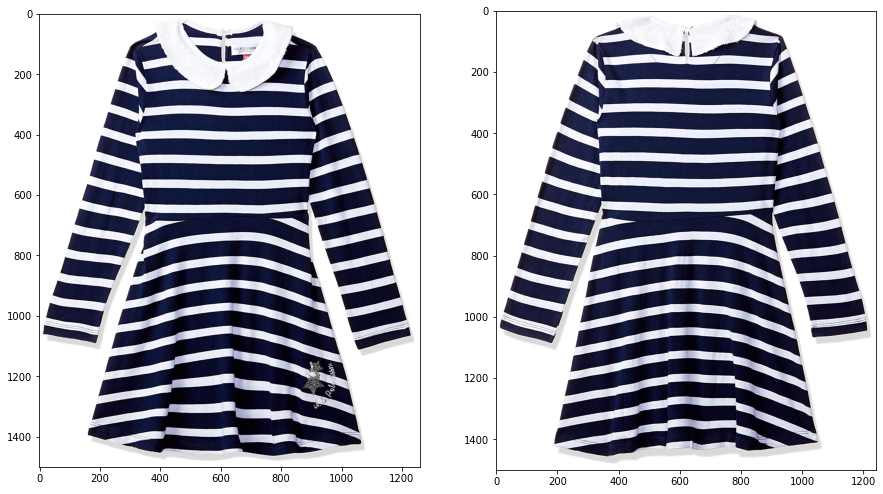

In [143]:
plt.figure(figsize=(15, 12))

plt.subplot(1,2,1)
plt.imshow(Image.open(example_img))

plt.subplot(1,2,2)
plt.imshow(Image.open(mapped_img))

plt.show()

### Intermediate Steps

In [131]:
A_key_points, A_description, B_key_points, B_description = orb_get_kp_and_descp(example_img, 
                                                                                mapped_img)

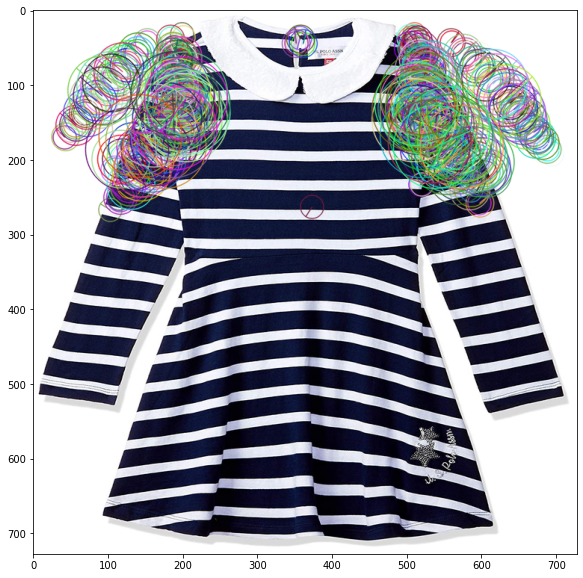

In [132]:
draw_key_points(A_key_points, example_img, 728, 728)

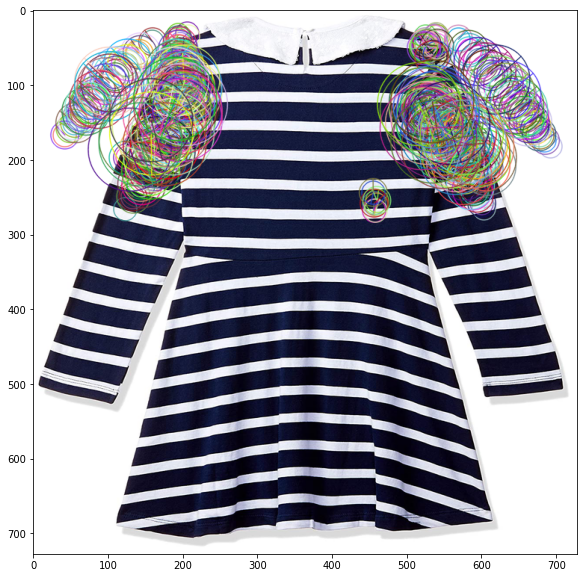

In [133]:
draw_key_points(B_key_points, mapped_img, 728, 728)

In [134]:
matches = brute_force_matcher(A_description, B_description, do_ratio_test=True, ratio_threshold=0.75)
len(matches)

51

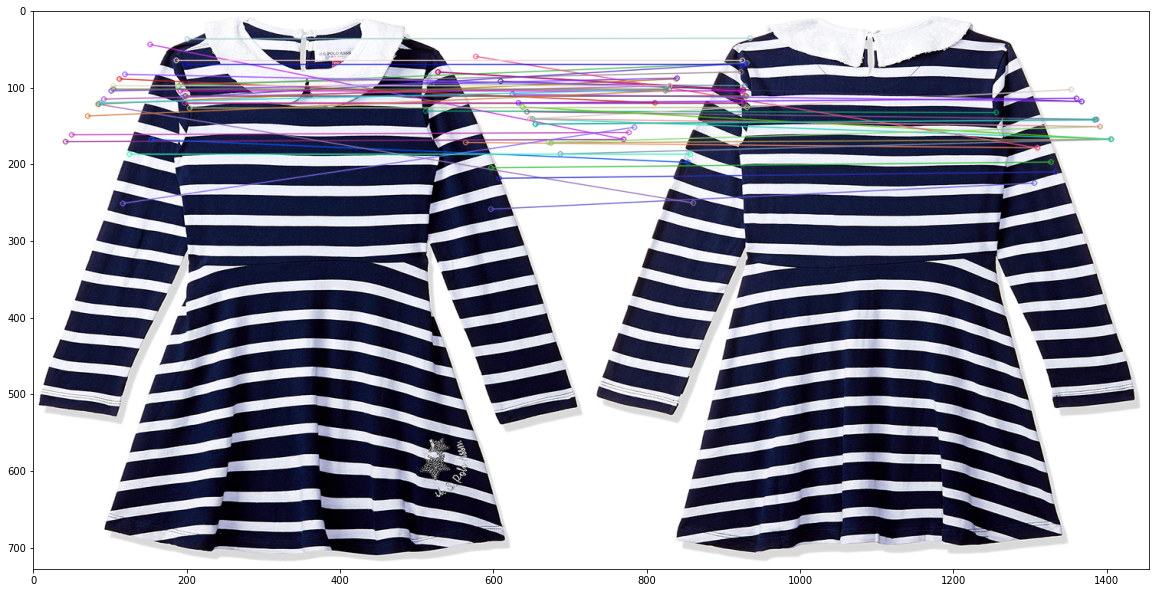

In [135]:
draw_matches(matches, A_key_points, B_key_points, 
             example_img, mapped_img, 728, 728)